2025-08-20 15:03:25,025 db.db INFO Creating database engine


Found 4575 date mention records from 233 unique files
Found 7435 total date mentions
Found 2526 unique dates


2025-08-20 15:04:18,375 matplotlib.category INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\adankert\AppData\Local\Temp\ipykernel_22100\2773991588.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dates_df, x='Date', y='Mentions',
2025-08-20 15:04:18,539 matplotlib.category INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\adankert\AppData\Local\Temp\ipykernel_22100\2773991588.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 


Summary Statistics:
Average mentions per date: 2.94
Files analyzed: 233
Most mentioned date: ('2025-08-20', 128)
Granularity breakdown: {'day': 4575}


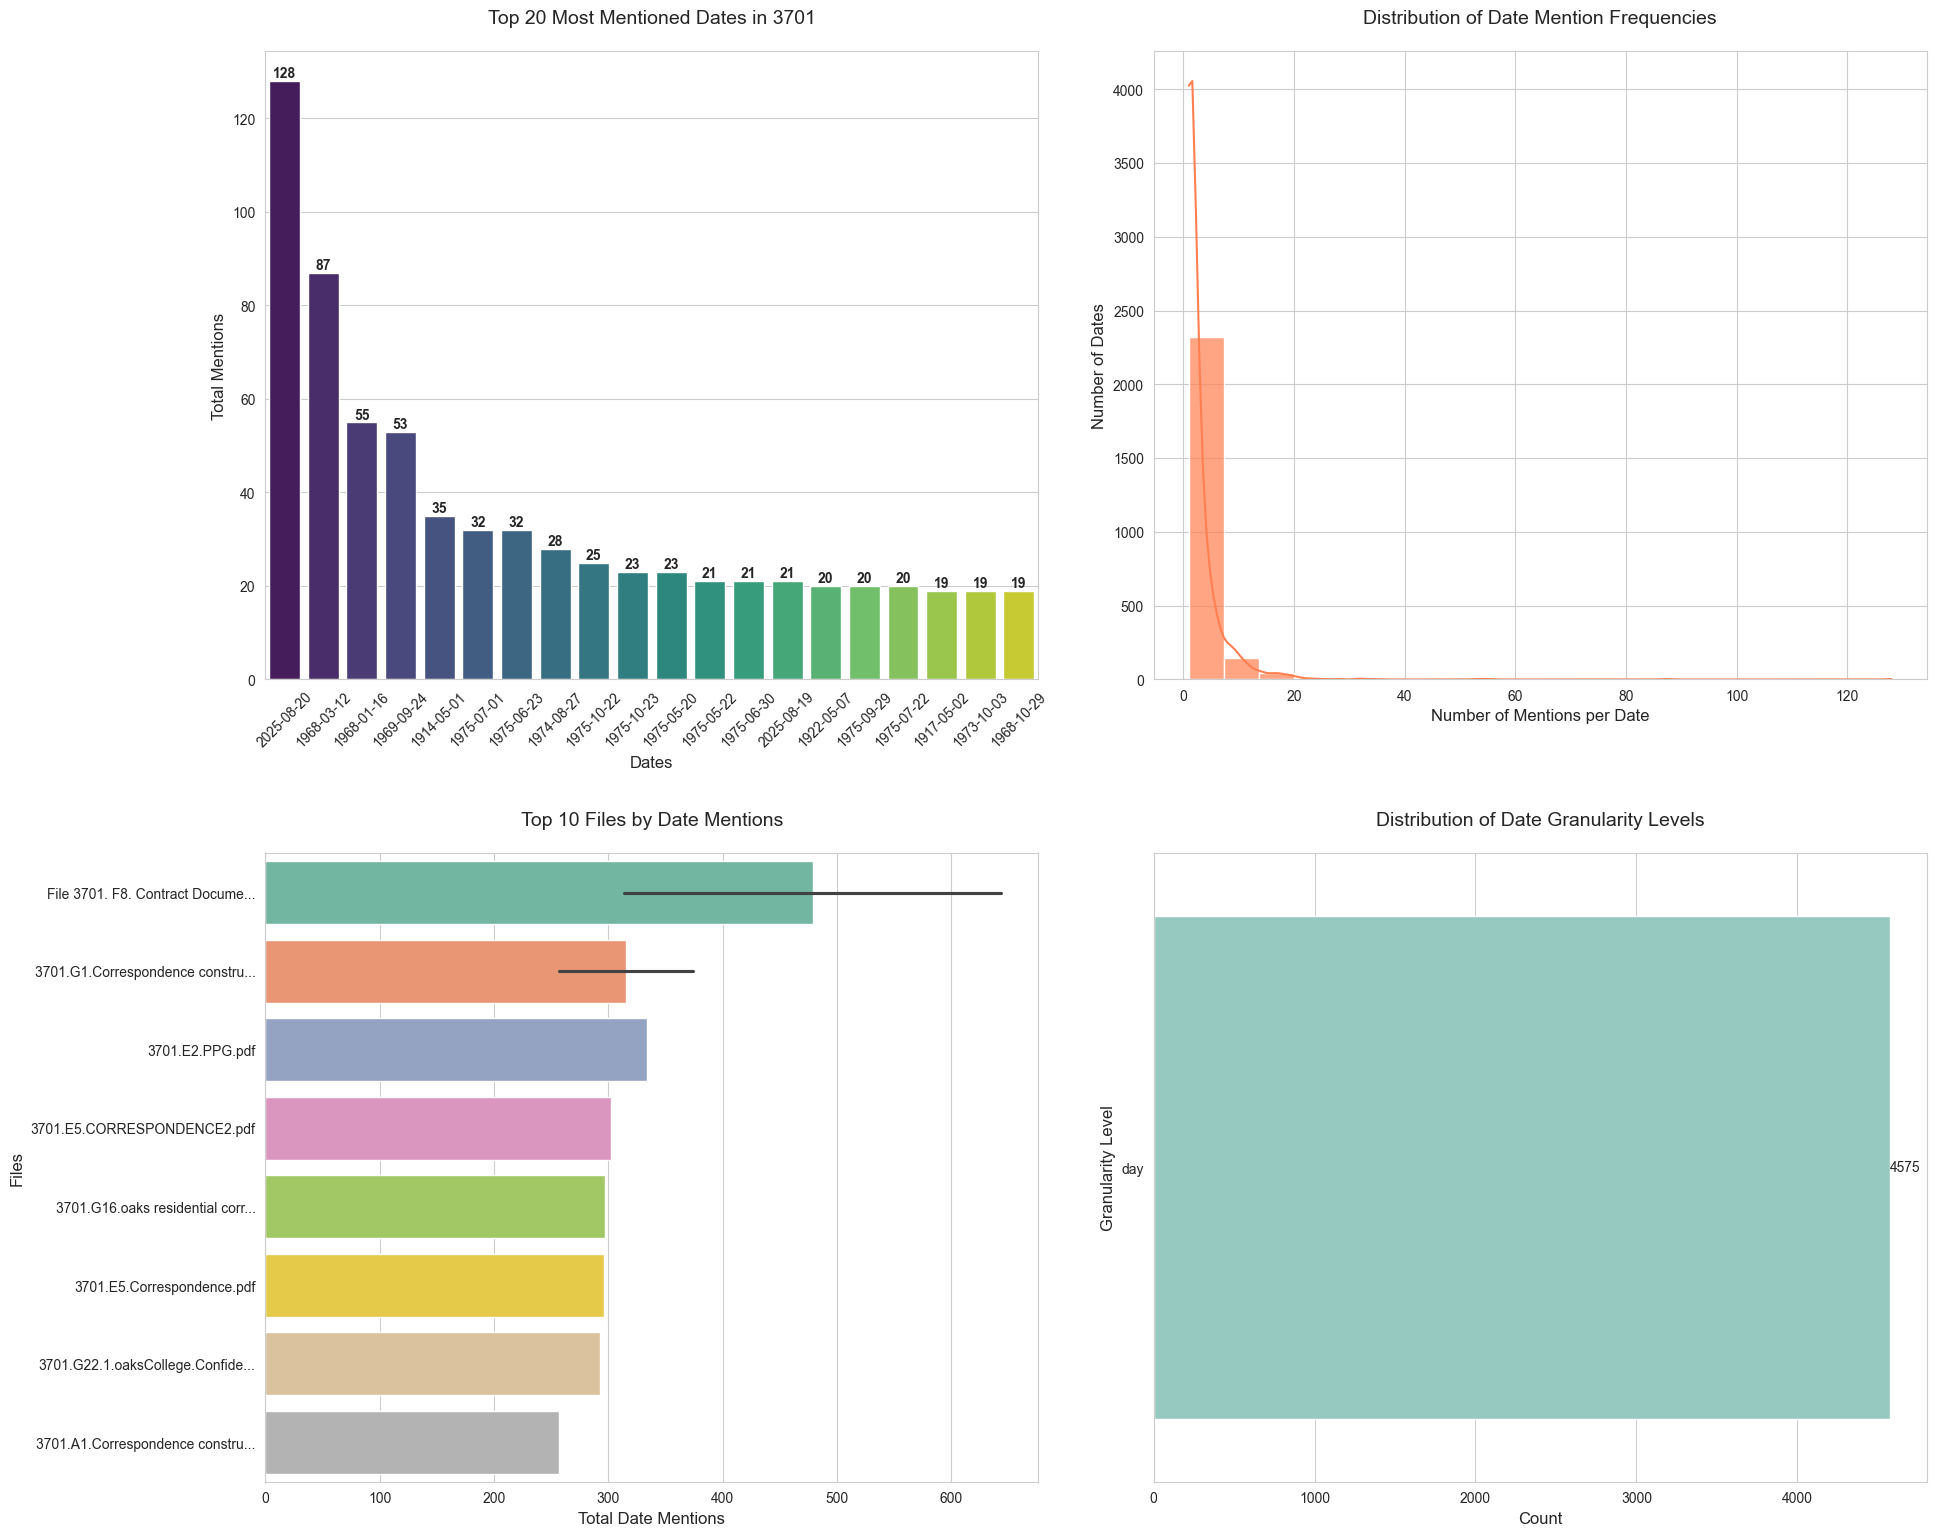

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pathlib import Path
from typing import Tuple, Optional
from db.db import get_db_engine
from db.models import FileLocation, FileDateMention, File
from utils import extract_server_dirs
from sqlalchemy.orm import sessionmaker

# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

def date_mentions_summary_viz_for_location(directory_path: str, 
                                   base_mount: str,
                                   limit_top_dates: int = 20) -> Tuple[Counter, plt.Figure]:
    """
    Creates plot where subplots show summary statistics of date mentions.

    Parameters
    ----------
    directory_path : str
        The directory path to analyze (will be converted to server directory format)
    base_mount : str
        The local mount point for the records share (e.g., "N:\\PPDO\\Records")
    limit_top_dates : int
        Number of top dates to show in the bar chart (default: 20)
    
    Returns
    -------
    Tuple[Counter, plt.Figure]
        Counter of date mentions and matplotlib figure
    """
    
    # Convert directory path to server directory format for database lookup
    try:
        server_dir_prefix = extract_server_dirs(directory_path, base_mount)
    except ValueError as e:
        print(f"Error: {e}")
        return Counter(), plt.figure()
    
    # Create database session
    
    try:
        df = pd.DataFrame()
        with sessionmaker(bind=get_db_engine())() as session:
            # Query for files in the directory and subdirectories using SQLAlchemy
            query_results = session.query(
                FileLocation.id,
                FileLocation.filename,
                FileLocation.file_server_directories,
                FileDateMention.mention_date,
                FileDateMention.granularity,
                FileDateMention.mentions_count,
                FileDateMention.extractor
            ).join(
                File, FileLocation.file_id == File.id
            ).join(
                FileDateMention, File.hash == FileDateMention.file_hash
            ).filter(
                FileLocation.file_server_directories.like(f"{server_dir_prefix}%")
            ).order_by(
                FileDateMention.mentions_count.desc()
            ).all()
            
            if not query_results:
                print(f"No date mentions found for files in directory: {directory_path}")
                print(f"Server directory pattern searched: {server_dir_prefix}")
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                ax.text(0.5, 0.5, f'No date mentions found in\n{directory_path}', 
                        ha='center', va='center', fontsize=16)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_title(f'Date Mentions Analysis: {directory_path}', fontsize=14, pad=20)
                return Counter(), fig
            
            # Convert query results to DataFrame
            df = pd.DataFrame(query_results, columns=[
                'file_id', 'filename', 'file_server_directories', 
                'mention_date', 'granularity', 'mentions_count', 'extractor'
            ])
        
            print(f"Found {len(df)} date mention records from {df['filename'].nunique()} unique files")

    except Exception as e:
        print(f"Error occurred while processing DataFrame: {e}")
        return Counter(), plt.figure()

    try:
        # Aggregate date mentions by mention_date
        date_counter = Counter()
        for _, row in df.iterrows():
            # Convert date to string for the counter
            date_str = row['mention_date'].strftime('%Y-%m-%d')
            date_counter[date_str] += row['mentions_count']
        
        print(f"Found {sum(date_counter.values())} total date mentions")
        print(f"Found {len(date_counter)} unique dates")
        
        # Create visualization with seaborn
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Bar chart of top dates using seaborn
        if date_counter:
            top_dates = date_counter.most_common(limit_top_dates)
            top_dates_df = pd.DataFrame(top_dates, columns=['Date', 'Mentions'])
            
            sns.barplot(data=top_dates_df, x='Date', y='Mentions', 
                       palette='viridis', ax=ax1)
            ax1.set_title(f'Top {len(top_dates)} Most Mentioned Dates in {Path(directory_path).name}', 
                         fontsize=14, pad=20)
            ax1.set_xlabel('Dates', fontsize=12)
            ax1.set_ylabel('Total Mentions', fontsize=12)
            ax1.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for i, v in enumerate(top_dates_df['Mentions']):
                ax1.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
        
        # 2. Histogram of mention frequency distribution
        frequency_counts = list(date_counter.values())
        sns.histplot(frequency_counts, bins=min(20, len(set(frequency_counts))), 
                    kde=True, color='coral', alpha=0.7, ax=ax2)
        ax2.set_xlabel('Number of Mentions per Date', fontsize=12)
        ax2.set_ylabel('Number of Dates', fontsize=12)
        ax2.set_title('Distribution of Date Mention Frequencies', fontsize=14, pad=20)
        
        # 3. Files with most date mentions
        file_mention_counts = df.groupby('filename')['mentions_count'].sum().sort_values(ascending=False).head(10)
        if not file_mention_counts.empty:
            file_df = pd.DataFrame({
                'filename': [name[:30] + '...' if len(name) > 30 else name for name in file_mention_counts.index],
                'mentions': file_mention_counts.values
            })
            
            sns.barplot(data=file_df, y='filename', x='mentions', 
                       palette='Set2', ax=ax3)
            ax3.set_title('Top 10 Files by Date Mentions', fontsize=14, pad=20)
            ax3.set_xlabel('Total Date Mentions', fontsize=12)
            ax3.set_ylabel('Files', fontsize=12)
        
        # 4. Distribution of date granularity with countplot
        if 'granularity' in df.columns:
            sns.countplot(data=df, y='granularity', palette='Set3', ax=ax4)
            ax4.set_ylabel('Granularity Level', fontsize=12)
            ax4.set_xlabel('Count', fontsize=12)
            ax4.set_title('Distribution of Date Granularity Levels', fontsize=14, pad=20)
            
            # Add value labels on bars
            for i, count in enumerate(df['granularity'].value_counts()):
                ax4.text(count + 1, i, str(count), va='center')
        else:
            ax4.text(0.5, 0.5, 'No granularity data available', 
                    ha='center', va='center', fontsize=14)
        
        plt.tight_layout(pad=3.0)
        
        # Print summary statistics
        print(f"\nSummary Statistics:")
        print(f"Average mentions per date: {sum(date_counter.values()) / len(date_counter):.2f}")
        print(f"Files analyzed: {df['filename'].nunique()}")
        print(f"Most mentioned date: {date_counter.most_common(1)[0] if date_counter else 'None'}")
        print(f"Granularity breakdown: {df['granularity'].value_counts().to_dict()}")
        
        return date_counter, fig

    except Exception as e:
        print(f"Error occurred while processing DataFrame into plot: {e}")
        return Counter(), plt.figure()

#Example usage:
base_mount = r"N:\PPDO\Records"
directory_to_analyze = r"N:\PPDO\Records\37xx   Oakes College\3701\3701"
date_counts, figure = date_mentions_summary_viz_for_location(directory_to_analyze, base_mount)
plt.show()

2025-08-22 14:53:54,538 db.db INFO Creating database engine



Summary Statistics:
Date range: 1962-01-01 to 2032-01-01
Date range span: 25567 days (839.9 months, 70.0 years)
Total unique documents with date mentions: 124
Time periods with documents: 43 / 71 years (60.6%)
Average documents per year: 4.41
Maximum documents in a single year: 57


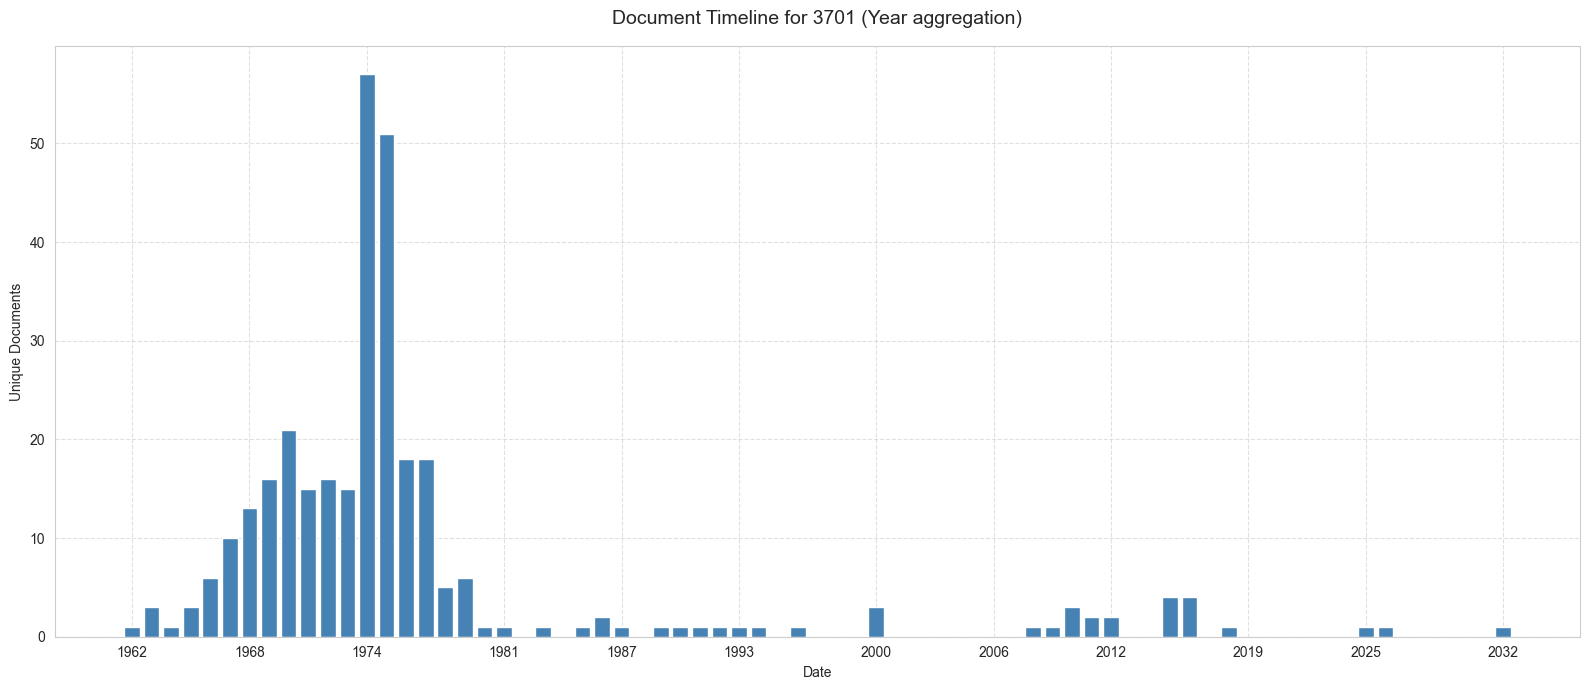

In [6]:
"""
Timeline viz for unique-document date mentions, with correct interval binning
and smart x‑axis tick density/labeling.

Key guarantees:
- Each file is counted at most once per interval (day/week/month/year).
- Weekly bins are anchored to Monday starts; labels show the mid‑week date.
- Ticks are thinned to `max_ticks` while preserving the full aggregation.
- Label formats adapt by interval and rotate 45° (except years).
"""
from __future__ import annotations
import math
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sqlalchemy.orm import sessionmaker
from db.db import get_db_engine
from db.models import FileLocation, FileDateMention, File
from utils import extract_server_dirs

# --- Styling ---------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.facecolor"] = "white"

# --- Helpers ---------------------------------------------------------------
FREQ_MAP = {
    "day": ("D", "%Y-%m-%d"),
    "week": ("W-MON", "%b %d, %Y"),  # bins anchor to Monday
    "month": ("MS", "%b %Y"),        # month starts
    "year": ("YS", "%Y"),            # year starts (Jan 1)
}


def _interval_start_series(dates: pd.Series, interval: str) -> pd.Series:
    """
    Return a datetime64[ns] series of interval starts for each date.
    Weeks are Monday‑anchored to match FREQ_MAP.
    """
    d = pd.to_datetime(dates, errors="coerce")
    if interval == "day":
        return d.dt.floor("D")
    elif interval == "week":
        return d.dt.to_period("W-MON").dt.start_time
    elif interval == "month":
        return d.dt.to_period("M").dt.start_time
    elif interval == "year":
        return d.dt.to_period("Y").dt.start_time
    else:
        raise ValueError(f"Invalid interval: {interval}")


def get_date_data_from_db(
    directory_path: str,
    base_mount: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> pd.DataFrame:
    """
    Query date mentions joined to files limited to a directory tree.
    Returns a DataFrame with file and date mention info.
    """
    try:
        server_dir_prefix = extract_server_dirs(directory_path, base_mount)
    except ValueError as e:
        print(f"Error: {e}")
        return pd.DataFrame()

    try:
        with sessionmaker(bind=get_db_engine())() as session:
            q = (
                session.query(
                    FileLocation.id.label("file_location_id"),
                    FileLocation.filename,
                    File.hash.label("file_hash"),
                    FileDateMention.mention_date,
                    FileDateMention.granularity,
                    FileDateMention.mentions_count,
                )
                .join(File, FileLocation.file_id == File.id)
                .join(FileDateMention, File.hash == FileDateMention.file_hash)
                .filter(FileLocation.file_server_directories.like(f"{server_dir_prefix}%"))
            )
            if start_date:
                q = q.filter(FileDateMention.mention_date >= pd.to_datetime(start_date))
            if end_date:
                q = q.filter(FileDateMention.mention_date <= pd.to_datetime(end_date))

            rows = q.all()
            if not rows:
                print(
                    f"No date mentions found for files in directory: {directory_path}\n"
                    f"Server directory pattern searched: {server_dir_prefix}"
                )
                return pd.DataFrame()

            df = pd.DataFrame(
                rows,
                columns=[
                    "file_location_id",
                    "filename",
                    "file_hash",
                    "mention_date",
                    "granularity",
                    "mentions_count",
                ],
            )
            df["mention_date"] = pd.to_datetime(df["mention_date"], errors="coerce")
            df = df.dropna(subset=["mention_date"]).copy()
            return df
    except Exception as e:
        print(f"Error occurred while querying database: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


# --- Aggregation logic (correct per-interval unique-file counting) ---------

def aggregate_by_interval(df: pd.DataFrame, interval: str) -> pd.DataFrame:
    """
    Aggregate to unique file count per interval start.
    Ensures each file_hash contributes at most 1 to a given interval.
    """
    if df.empty:
        return pd.DataFrame(columns=["interval_start", "document_count"]) 

    # Compute interval starts and drop duplicates by (file, interval)
    s = _interval_start_series(df["mention_date"], interval)
    work = df.assign(interval_start=s)[["file_hash", "interval_start"]].drop_duplicates()

    # Count unique files per interval (size after dedup is already unique by file)
    agg = (
        work.groupby("interval_start", as_index=False)
        .size()
        .rename(columns={"size": "document_count"})
        .sort_values("interval_start")
    )
    return agg


# --- Fill the complete timeline -------------------------------------------

def create_complete_timeline(
    aggregated_df: pd.DataFrame,
    interval: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> pd.DataFrame:
    """
    Fill in missing intervals in the timeline with zero counts.
    Returns a DataFrame with all intervals between min and max date.
    """
    if aggregated_df.empty:
        return pd.DataFrame(columns=["date", "document_count"]) 

    freq, _fmt = FREQ_MAP[interval]
    min_date = pd.to_datetime(start_date) if start_date else aggregated_df["interval_start"].min()
    max_date = pd.to_datetime(end_date) if end_date else aggregated_df["interval_start"].max()

    # Ensure inclusive range covers the last bin
    rng = pd.date_range(start=min_date, end=max_date, freq=freq)
    full = pd.DataFrame({"date": rng})

    out = (
        full.merge(
            aggregated_df.rename(columns={"interval_start": "date"}),
            on="date",
            how="left",
        )
        .fillna({"document_count": 0})
        .astype({"document_count": int})
    )
    return out


# --- Tick calculation and formatting ---------------------------------------

def prepare_tick_positions(dates: pd.Series, max_ticks: int = 12) -> List[pd.Timestamp]:
    """
    Calculate evenly spaced tick positions for the x-axis.
    Returns a list of pd.Timestamp objects for ticks.
    """
    if dates.empty:
        return []
    n = len(dates)
    if n <= max_ticks:
        return dates.tolist()
    # Evenly spaced indices, always include first/last
    idx = np.linspace(0, n - 1, num=max_ticks, dtype=int)
    idx[0] = 0
    idx[-1] = n - 1
    return [dates.iat[i] for i in idx]


def apply_axis_format(ax, interval: str, max_ticks: int):
    """
    Set x-axis tick formatting and label rotation based on interval.
    """
    # Formatter per interval; weeks show mid‑week label (start + 3d)
    if interval == "year":
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        rot, ha = 0, "center"
    elif interval == "month":
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        rot, ha = 45, "right"
    elif interval == "week":
        def _fmt_week(x, pos):
            try:
                dt = mdates.num2date(x)  # naive datetime from matplotlib float
                mid = dt + pd.Timedelta(days=3)
                return mid.strftime("%b %d, %Y")
            except Exception:
                return ""
        ax.xaxis.set_major_formatter(FuncFormatter(_fmt_week))
        rot, ha = 45, "right"
    else:  # day
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        rot, ha = 45, "right"

    plt.setp(ax.get_xticklabels(), rotation=rot, ha=ha)


# --- Plotting ---------------------------------------------------------------

def create_timeline_plot(
    timeline_df: pd.DataFrame,
    directory_path: str,
    interval: str,
    max_ticks: int = 12,
    type_str: str = 'line',  # 'line' or 'bar'
) -> plt.Figure:
    """
    Create a timeline plot (line or bar) of unique document counts per interval.
    Returns a matplotlib Figure.
    """
    if timeline_df.empty:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.text(
            0.5,
            0.55,
            f"No date mentions found in\n{directory_path}",
            ha="center",
            va="center",
            fontsize=14,
        )
        ax.set_axis_off()
        fig.suptitle("Document Date Timeline", fontsize=14)
        return fig

    # Figure sizing: wider with more bins
    n_bins = len(timeline_df)
    fig_w = 12 if n_bins <= 60 else 16 if n_bins <= 150 else 20
    fig, ax = plt.subplots(figsize=(fig_w, 7))

    if type_str == 'bar':
        # compute a reasonable bar width in days
        dates = timeline_df['date']
        if len(dates) > 1:
            delta_days = (dates.iloc[1] - dates.iloc[0]).days
        else:
            delta_days = 1
        width = delta_days * 0.8

        # draw bars directly
        ax.bar(
            dates,
            timeline_df['document_count'],
            width=width,
            color='steelblue',
            align='center',
        )
    else:
        sns.lineplot(
            data=timeline_df,
            x="date",
            y="document_count",
            marker="o",
            linewidth=1.6,
            markersize=4,
            ax=ax,
        )

    # Title/labels
    location_name = Path(directory_path).name
    ax.set_title(
        f"Document Timeline for {location_name} ({interval.capitalize()} aggregation)",
        fontsize=14,
        pad=16,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Unique Documents")

    # Ticks
    ticks = prepare_tick_positions(timeline_df["date"], max_ticks=max_ticks)
    if ticks:
        ax.set_xticks(ticks)
    apply_axis_format(ax, interval, max_ticks)

    # Light grid
    ax.grid(True, linestyle="--", alpha=0.6)

    if type_str == 'line':
        ax.fill_between(
            timeline_df["date"],
            0,
            timeline_df["document_count"],
            alpha=0.18,
            step=None,
        )

    fig.tight_layout()
    return fig


# --- Stats -----------------------------------------------------------------

def print_timeline_stats(timeline_df: pd.DataFrame, interval: str, original_df: pd.DataFrame):
    """
    Print summary statistics for the timeline visualization.
    """
    if timeline_df.empty:
        return
    min_date = timeline_df["date"].min()
    max_date = timeline_df["date"].max()
    span_days = (max_date - min_date).days
    total_unique_files = original_df["file_hash"].nunique()
    periods_with_docs = int((timeline_df["document_count"] > 0).sum())
    print("\nSummary Statistics:")
    print(f"Date range: {min_date:%Y-%m-%d} to {max_date:%Y-%m-%d}")
    print(
        f"Date range span: {span_days} days ({span_days/30.44:.1f} months, {span_days/365.25:.1f} years)"
    )
    print(f"Total unique documents with date mentions: {total_unique_files}")
    print(
        f"Time periods with documents: {periods_with_docs} / {len(timeline_df)} {interval}s "
        f"({periods_with_docs/len(timeline_df)*100:.1f}%)"
    )
    print(f"Average documents per {interval}: {timeline_df['document_count'].mean():.2f}")
    print(f"Maximum documents in a single {interval}: {timeline_df['document_count'].max()}")


# --- Orchestrator ----------------------------------------------------------

def document_date_timeline_viz(
    directory_path: str,
    base_mount: str,
    agg_interval: str = "day", # "day", "week", "month", or "year" 
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    max_xtick_labels: int = 12,
    type_str = 'line'
) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    Orchestrate the timeline visualization: query, aggregate, plot, and print stats.
    Returns the timeline DataFrame and matplotlib Figure.
    """
    # Validate interval
    if agg_interval not in FREQ_MAP:
        print(f"Warning: Invalid interval '{agg_interval}'. Using 'day' instead.")
        agg_interval = "day"

    # Data
    df = get_date_data_from_db(directory_path, base_mount, start_date, end_date)
    if df.empty:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.text(
            0.5,
            0.55,
            f"No date mentions found in\n{directory_path}",
            ha="center",
            va="center",
            fontsize=14,
        )
        ax.set_axis_off()
        fig.suptitle("Document Date Timeline", fontsize=14)
        return pd.DataFrame(columns=["date", "document_count"]), fig

    # Aggregate → complete timeline → plot
    aggregated = aggregate_by_interval(df, agg_interval)
    timeline_df = create_complete_timeline(aggregated, agg_interval, start_date, end_date)
    fig = create_timeline_plot(timeline_df=timeline_df,
                               directory_path=directory_path,
                               interval=agg_interval,
                               max_ticks =max_xtick_labels,
                               type_str=type_str)

    # Stats
    print_timeline_stats(timeline_df, agg_interval, df)

    return timeline_df, fig


# --- Example (commented) ---------------------------------------------------
base_mount = r"N:\\PPDO\\Records"
directory_to_analyze = r"N:\\PPDO\\Records\\37xx   Oakes College\\3701\\3701"
timeline_df, fig = document_date_timeline_viz(
    directory_to_analyze,
    base_mount,
    agg_interval="year",
    max_xtick_labels=12,
    type_str='bar'
)
plt.show()
